# Fig1_Catchments-PR.ipynb

#!/usr/bin/env python

    File name: Fig1_Catchments-PR.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 19.04.2018
    Date last modified: 19.04.2018

    ############################################################## 
    Purpos:
    Collects information from previously run analysis and plots them


In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
from mpl_toolkits import basemap
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
from scipy import signal
from numpy.linalg import lstsq
import random

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

def MakeShapefile(Regions,
                 LonW,
                 LatW,
                 sShapefiles):
    
    rgrGridCells=[(LonW.ravel()[ii],LatW.ravel()[ii]) for ii in range(len(LonW.ravel()))]
    HUC4_WRF=np.zeros((LonW.shape[0]*LonW.shape[1]))
    for bs in range(len(Regions)):
        Basins = [Regions[bs]]
        for ba in range(len(Basins)):
#             print('        process '+Basins[ba])
            sf = shp.Reader(sShapefiles+Basins[ba])
            df = read_shapefile(sf)
            for sf in range(df.shape[0]):
                ctr = df['coords'][sf]
                if len(ctr) > 10000:
                    ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
                else:
                    ctr=np.array(ctr)
                grPRregion=mplPath.Path(ctr)
                TMP=np.array(grPRregion.contains_points(rgrGridCells))
                HUC4_WRF[TMP == 1]=bs+1
    HUC4_WRF=np.reshape(HUC4_WRF, (LatW.shape[0], LatW.shape[1]))
    return HUC4_WRF

def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height]) #,axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

### Setup

In [2]:
sPlotDir='/glade/u/home/prein/projects/Arizona_WTing/plots/Fig01/'
sDataDir='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/'
DW_Regions=['1501','1502','1503','1504','1505','1506','1507','1810','HUC6-00','HUC6-01','HUC6-02','HUC6-03','HUC6-04','HUC6-05']
sRegNames=['1501','1502','1503','1504','1505','1506','1507','1810', '130100','130201','130202','130600','130301','140801']
HUC6 = ['130100','130201','130202','130600','130301','140801']
sMonths='6-7-8-9-10'
Season = 'JJASO'
YYYY_stamp='1982-2018'
rgsWTvars=['PSL','U850','V850','UV850','MFL850',  'MFL500', 'Q850', 'Q500', 'ZG500', 'UV200','T850','T500']
iNrOfExtremes = 13514

VarComp = [['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850']]

Basins=['AZ_West', 'AZ_East', 'NM_North','NM_South'] 
COLORS = ['#e31a1c','#fb9a99','#1f78b4','#33a02c']
Region=Basins
sSubregion='/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/'

WTfocCatch =['1501','1502','HUC6-00','HUC6-03']

PercVarSel=10

### Read Prism and calculate basin statistics

In [3]:
SaveDir='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/NMME/PR/'
SAVE = SaveDir+'PRISM_PR-observations_Monsoon-Basins_daily.npz'
if os.path.exists(SAVE) == False:
    # Calculate Mask first
    ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/PRISM_daily_ppt_2014.nc', mode='r') # open the netcdf file
    rgrLatPR=np.squeeze(ncid.variables['lat'][:])
    rgrLonPR=np.squeeze(ncid.variables['lon'][:])
    ncid.close()

    MASK = MakeShapefile(Basins,
                     rgrLonPR,
                     rgrLatPR,
                     sSubregion)

    # Read the PRISM data
    Time_PRISM = pd.date_range(datetime.datetime(1981, 1, 1,0), end=datetime.datetime(2018, 12, 31,12), freq='d')
    rgiYY = np.unique(Time_PRISM.year)

    rgrPRdata = np.zeros((len(Time_PRISM), len(Basins))); rgrPRdata[:] = np.nan
    for yy in range(len(rgiYY)):
        print('working on '+str(rgiYY[yy]))
        rgdTimeYY = pd.date_range(datetime.datetime(rgiYY[0]+yy, 1, 1,0), end=datetime.datetime(rgiYY[0]+yy, 12, 31,23), freq='d')
        rgiDD=np.where(((rgdTimeYY.year == rgiYY[0]+yy)))[0]
        ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/PRISM_daily_ppt_'+str(rgiYY[0]+yy)+'.nc', mode='r') # open the netcdf file
        PR_PRISM_DD = np.squeeze(ncid.variables['PR'][rgiDD,:])
        ncid.close()
        # calcualte averages over regions
        for ba in range(len(Basins)):
            rgrPRdata[rgiDD,ba] = np.mean(PR_PRISM_DD[:,MASK == (ba+1)], axis=(1))


    np.savez(SAVE,
        Time_PRISM =Time_PRISM,
        basins = Basins,
        precipitation = rgrPRdata,
        precip_dims = 'year,month,basin')
else:
    DATA = np.load(SAVE)
    Time_PRISM = pd.to_datetime(DATA['Time_PRISM'])
    rgrPRdata = DATA['precipitation']
    precip_dims = DATA['precip_dims']
    


In [4]:
np.arange(-50,70,10)

array([-50, -40, -30, -20, -10,   0,  10,  20,  30,  40,  50,  60])

### Start collecting data and plotting

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: The following kwargs were not used by contour: 'zlevel'
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=59,61 m=3306 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:202: UserWarning: The following kwargs were not used by contour: 'zlevel'
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:286: RuntimeWarning: Mean of empty slice
/glade/u/apps/dav/opt/python/3.7.5/

        Plot map to: /glade/u/home/prein/projects/Arizona_WTing/plots/Fig01/Fig01.pdf


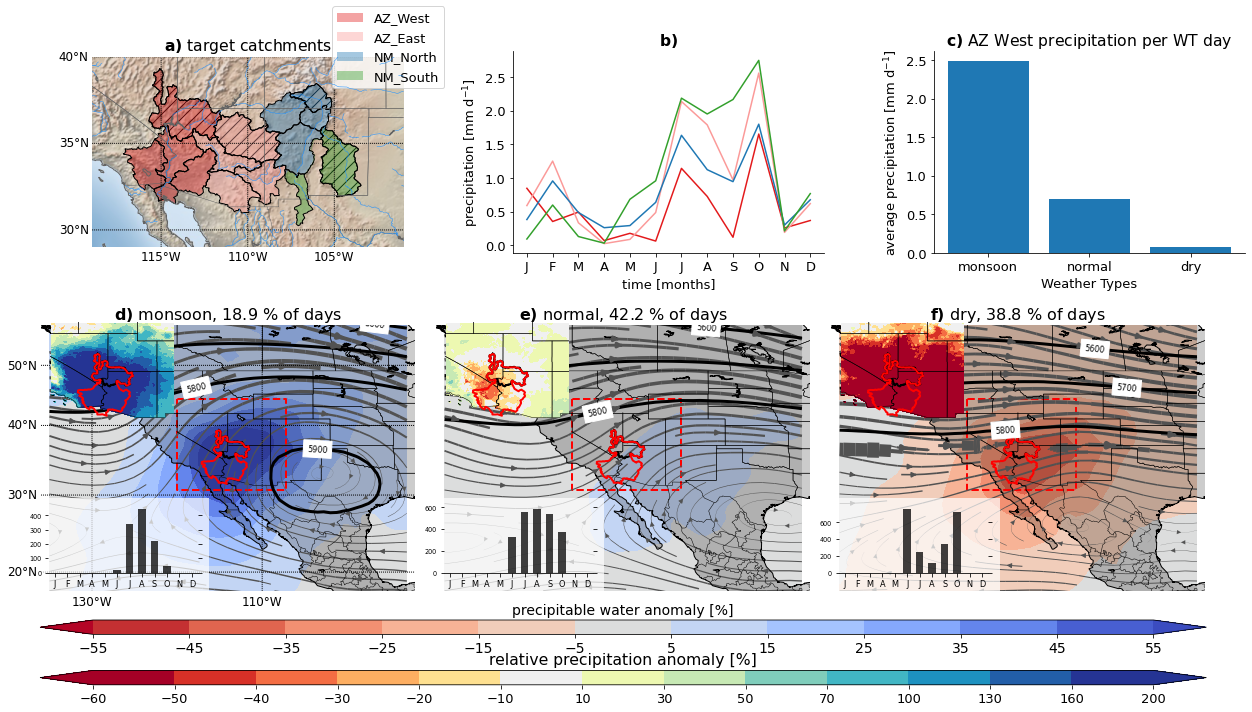

In [5]:
from mpl_toolkits import basemap
plt.rcParams.update({'font.size': 13})
rgsLableABC=list(string.ascii_lowercase)

fig = plt.figure(figsize=(18,10))

gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.09, right=0.98,
           bottom=0.65, top=0.93,
           wspace=0.35, hspace=0.25)


# ======================================================
# --- PLOT THE CATCHMENTS ON A MAP ----
ax = plt.subplot(gs1[0,0])
plt.axis('off')
m = Basemap(projection='cea',\
            llcrnrlat= 29 ,urcrnrlat=40,\
            llcrnrlon=-119,urcrnrlon=-101,resolution='i', epsg=4269) #, fix_aspect=False) #, epsg=4269)
m.shadedrelief()
m.drawcountries(color='#636363', zorder=10)
m.drawstates(color='#636363', zorder=10)
m.drawrivers(color='dodgerblue',linewidth=0.5,zorder=10)  
# m.fillcontinents(color='#f0f0f0', zorder=1)
m.drawcoastlines(color='#636363', zorder=10)

parallels = np.arange(-80.,81,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,True,False], fontsize=12)
meridians = np.arange(10.,351.,5.)
m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=12)

# plot sub-catchments
for re2 in range(len(DW_Regions)):
    if DW_Regions[re2][:3] != 'HUC':
        sf = shp.Reader('/glade/campaign/mmm/c3we/prein/Shapefiles/HUC4/NHD_H_'+DW_Regions[re2]+'_HU4_Shape/Shape/WBDHU4')
        df = read_shapefile(sf)
        for sf in range(df.shape[0]):
            ctr = df['coords'][sf]
            if len(ctr) > 10000:
                ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
            else:
                ctr=np.array(ctr)
        # add shapefile of catchment
        XX,YY=m(ctr[:,0], ctr[:,1])
        m.plot(XX,YY, c='k', lw=1)
        
        if DW_Regions[re2] in WTfocCatch:
#             m.plot(XX,YY, c='r', lw=1)
            ax.fill(XX,YY, fill=False, hatch='//')
sSubregionPR='/glade/campaign/mmm/c3we/prein/Shapefiles/HUC6/NewMexico/'+DW_Regions[8][:-3]
sf = shp.Reader(sSubregionPR)
df = read_shapefile(sf)
for sf in range(df.shape[0]):
    ctr = df['coords'][sf]
    if len(ctr) > 10000:
        ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
    else:
        ctr=np.array(ctr)
    # add shapefile of catchment
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='k', lw=1)
    if sf in [0,3]:
        ax.fill(XX,YY, fill=False, hatch='//')

            
# plot clustered regions
for ba in range(len(Basins)):
    sf = shp.Reader(sSubregion+Basins[ba])
    df = read_shapefile(sf)
    for sf in range(df.shape[0]):
        ctr = df['coords'][sf]
        if len(ctr) > 10000:
            ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
        else:
            ctr=np.array(ctr)
    # add shapefile of catchment
    XX,YY=m(ctr[:,0], ctr[:,1])
#     m.plot(XX,YY, c='r', lw=2)
    ax.fill(XX,YY, COLORS[ba], alpha=0.4, zorder=2, label=Basins[ba])


plt.title(r"$\bf{" + str(rgsLableABC[0])+ ")}$ target catchments")
plt.legend(bbox_to_anchor=(0.75, 0.8))


# ======================================================
# --- PLOT MONTHLY AVERAGE PRECIPITATION ----
# load the combined HUC6 basin precipitation (is highly correlated with the original data)
# Data comes from - ~/projects/Arizona_WTing/programs/NMME_PR_prediction/NMME_PR_prediction.ipynb
DATA = np.load('/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/NMME/PR/PRISM_PR-observations_Monsoon-Basins.npz')
PR_basins = DATA['precipitation']

ax = plt.subplot(gs1[0,1])
Prism_MM = np.array([np.nanmean(rgrPRdata[Time_PRISM.month == (mm+1),:], axis=0) for mm in range(12)])
IQR = np.array([np.nanpercentile(rgrPRdata[Time_PRISM.month == (mm+1),:], (25,75) ,axis=0) for mm in range(12)])
Mon = np.array(['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.plot(range(12), Prism_MM[:,0], color = COLORS[0])
# ax.fill_between(range(12), IQR[:,0,0], IQR[:,1,0], color=COLORS[0], alpha=0.1)
plt.plot(range(12), Prism_MM[:,1], color = COLORS[1])
plt.plot(range(12), Prism_MM[:,2], color = COLORS[2])
plt.plot(range(12), Prism_MM[:,3], color = COLORS[3])
ax.set_xticks(np.array(range(12)))
ax.set_xticklabels(Mon)

ax.set_xlabel('time [months]')
ax.set_ylabel('precipitation [mm d$^{-1}$]')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title(r"$\bf{" + str(rgsLableABC[1])+ ")}$")



# ======================================================
# --- PLOT CENTROID MAPS ----

# load data from - projects/Arizona_WTing/programs/WTing/Centroids-and-Scatterplot.py
DATA = np.load('/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/1501_XWT-centroid_data-for-plot.npz',allow_pickle=True)
rgrLonWT=DATA['rgrLonWT']
rgrLatWT=DATA['rgrLatWT']
rgrLatWT_SR=DATA['rgrLatWT_SR']
rgrLonWT_SR=DATA['rgrLonWT_SR']
rgrWTdata=DATA['rgrWTdata']
rgrWTcentroids=DATA['rgrWTcentroids']
rgsWTvarsA=list(DATA['rgsWTvarsA'])
lats=DATA['lats']
lons=DATA['lons']
ctr=DATA['ctr']
rgdTime=pd.to_datetime(DATA['rgdTime'])
rgrClustersFin=DATA['rgrClustersFin']

# Load the data from - projects/Arizona_WTing/programs/WTing/Centroids-and-Scatterplot.py
DATA = np.load('/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/1501_XWT-precipitation-for-plot.npz')
rgrLonPR_SR=DATA['rgrLonPR_SR']
rgrLatPR_SR=DATA['rgrLatPR_SR']
rgrPRrecords=DATA['rgrPRrecords']
rgrPRdataPlot=DATA['rgrPRdata']
rgdTimePR=pd.to_datetime(DATA['rgdTime'])

gs2 = gridspec.GridSpec(1,3)
gs2.update(left=0.05, right=0.95,
           bottom=0.18, top=0.55,
           wspace=0.05, hspace=0.20)
# rllcrnrlat,urcrnrlat,llcrnrlon,urcrnrlon=np.min(rgrLatPR_SR),np.max(rgrLatPR_SR),np.min(rgrLatPR_SR),np.max(rgrLatPR_SR)

WTsort = [0,2,1]
WT_names = ['monsoon','normal','dry']
for pa in range(3):
    dLat=((52-25)/2.)*1.5
    dLon=((130-75)/2.)*0.8
    rllcrnrlat=np.mean((rgrLatWT_SR.min(),rgrLatWT_SR.max()))-dLat
    urcrnrlat=np.mean((rgrLatWT_SR.min(),rgrLatWT_SR.max()))+dLat
    llcrnrlon=np.mean((rgrLonWT_SR.min(),rgrLonWT_SR.max()))-dLon
    urcrnrlon=np.mean((rgrLonWT_SR.min(),rgrLonWT_SR.max()))+dLon
    
    # define margins of subplot (see http://matplotlib.org/users/gridspec.html)
    iSampleSize=np.sum(rgrClustersFin[1] == pa)
    ax = plt.subplot(gs2[0,WTsort[pa]])
    try:
        m = Basemap(projection='cea',                    
                    llcrnrlat= rllcrnrlat ,urcrnrlat=urcrnrlat,                    
                    llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,resolution='l') #, fix_aspect=False)
    except:
        stop()
    plt.axis('off')
    xi, yi = m(rgrLonWT, rgrLatWT)
    rgrColorTable=['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffff','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695'][::-1]

    # plot PW anomalies
    iContNr=len(rgrColorTable)+1
    clevs=np.arange(-55,65,10)
    rgrDataAct=rgrWTcentroids[pa, :,:,rgsWTvarsA.index('tcw')]
    rgrDataAct = ((rgrDataAct-np.mean(rgrWTdata[:,:,:,rgsWTvarsA.index('tcw')],axis=0))/np.mean(rgrWTdata[:,:,:,rgsWTvarsA.index('tcw')],axis=0))*100.
    cs = m.contourf(xi,yi,rgrDataAct,clevs,cmap='coolwarm_r', extend='both', alpha=1, zlevel=20)
    
    
#     # plot wind field
#     iLev=1; iDist=4
#     Q = plt.quiver(xi[::iDist, ::iDist],yi[::iDist, ::iDist],rgrWTcentroids[pa,::iDist,::iDist,1],
#                    rgrWTcentroids[pa,::iDist,::iDist,2], units='width',zorder = 1, pivot='middle',width=0.004, scale=150)
#     if pa == 0:
#         qk = ax.quiverkey(Q, 0.95, 1.05, 10, r'$10 \frac{m}{s}$', labelpos='E') #,coordinates='figure')

    # STREAMPLOT
    from scipy.interpolate import interp2d
    # regularly spaced grid spanning the domain of x and y 
    xii = np.linspace(xi.min(), xi.max(), xi.size)
    yii = np.linspace(yi.min(), yi.max(), yi.size)
    # bicubic interpolation
    uCi = interp2d(xi, yi, rgrWTcentroids[pa,:,:,1])(xii, yii)
    vCi = interp2d(xi, yi, rgrWTcentroids[pa,:,:,2])(xii, yii)
    speed = (uCi**2 + vCi**2)**0.5
    m.streamplot(xii,yii, uCi, vCi, linewidth=0.3*speed, color='#525252') #, cmap=plt.cm.autumn, linewidth=0.5*speed)



    # plot geopotential height
    iContNr=20
    clevs=np.arange(0,100000,100)
    CS=m.contour(xi[:,:],yi[:,:],rgrWTcentroids[pa,:,:,rgsWTvarsA.index('z')]/9.81,levels=clevs.astype('int'),
                 colors='k',linewidths=3, zlevel=2) #['#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#005a32'])
    clabels=plt.clabel(CS, inline=1, fontsize=8, fmt='%d')
    [txt.set_backgroundcolor('white') for txt in clabels]
    # plot cluster region
    x, y = m(lons,lats)
    m.plot(x,y, lw=2, ls='--', c='r', zorder=1)

    # Lable the map
    plt.title(r"$\bf{" + str(rgsLableABC[WTsort[pa]+3])+ ")}$"+' '+WT_names[WTsort[pa]]+', '+str(np.round((iSampleSize/len(rgdTime))*100,1))+' % of days', fontsize=16)
    
    m.drawcoastlines(color='k')
    m.drawcountries(color='k')
    m.drawstates(color='k')
    m.fillcontinents(color='k',lake_color='white', alpha=0.2)
    # add shapefile of catchment
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='k', lw=2)
    
    # plot clustered regions
    for ba in [0]:
        sf = shp.Reader(sSubregion+Basins[ba])
        df = read_shapefile(sf)
        for sf in range(df.shape[0]):
            ctr1 = df['coords'][sf]
            if len(ctr1) > 10000:
                ctr1=np.array(ctr1)[::100,:] # carsen the shapefile accuracy
            else:
                ctr1=np.array(ctr1)
        # add shapefile of catchment
        XX,YY=m(ctr1[:,0], ctr1[:,1])
        m.plot(XX,YY, c='r', lw=2)
    
    if pa == 0:
        parallels = np.arange(0.,81,10.)
        # labels = [left,right,top,bottom]
        m.drawparallels(parallels,labels=[True,False,True,False], fontsize=12)
        meridians = np.arange(10.,351.,20.)
        m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=12)

    # Add Histogram in the lower left corner
    rect = [0.02,0.07,0.4,0.25]
    from matplotlib.patches import Rectangle
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((0, 0), 0.45, 0.35, facecolor="white", transform = ax.transAxes, alpha=0.7,zorder = 100))
    
    ax1 = add_subplot_axes(ax,rect)
    # plt.axis('off')
    rgiMonths = np.array([rgdTime[rgrClustersFin[1] == pa][nn].month for nn in range(len(rgdTime[rgrClustersFin[1] == pa]))])
    ax1.hist(rgiMonths,np.array(range(1,14,1)), facecolor='k', alpha=0.75,rwidth=0.6)
    ax1.set_xticks(np.array(range(1,13,1))+0.5)
    ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.xaxis.set_ticks_position('bottom')
    ax1.set_xlim([1,13])
    # ax2.yaxis.set_ticks_position('left')
    ax1.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        right='off',         # ticks along the top edge are off
        labelleft='off') # labels along the bottom edge are off
    ax1.patch.set_alpha(0.0)

    
    # ======================================================
    # --- PLOT PRECIPITATION ANOMALY MAPS IN INLET ----

    rllcrnrlat,urcrnrlat,llcrnrlon,urcrnrlon=np.min(rgrLatPR_SR),np.max(rgrLatPR_SR),np.min(rgrLonPR_SR),np.max(rgrLonPR_SR)
    rllcrnrlat=rllcrnrlat-(urcrnrlat-rllcrnrlat)*0.03
    urcrnrlat=urcrnrlat+(urcrnrlat-rllcrnrlat)*0.01
    llcrnrlon=llcrnrlon-abs(llcrnrlon-urcrnrlon)*0.01
    urcrnrlon=urcrnrlon+abs(llcrnrlon-urcrnrlon)*0.01

    # define margins of subplot (see http://matplotlib.org/users/gridspec.html)
    iSampleSize=np.sum(rgrClustersFin[1] == pa)
        
    # Add inlet in top left corner
    rect = [0.0,0.63,0.38,0.38]
    currentAxis = plt.gca()    
    ax2 = add_subplot_axes(ax,rect)
    
    rAvPR=np.nanmean(rgrPRrecords[rgrClustersFin[1] == pa])
    rgrDataAct = np.nanmean(rgrPRdataPlot[rgrClustersFin[1] == pa], axis=0)
    m = Basemap(projection='cea',                    
                llcrnrlat= rllcrnrlat ,urcrnrlat=urcrnrlat,                    
                llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,resolution='i', fix_aspect=True)
    plt.axis('off')
    xi, yi = m(rgrLonPR_SR, rgrLatPR_SR)
    #Load ColorMap
    Colors = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#f0f0f0','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494','#081d58']
    clevs=np.arange(-100,120,20)  #np.append([0],clevs); clevs[1]=0.1
    clevs = [-60, -50,  -40,  -30, -20,-10, 10,30,50,70,100,130,160,200]
    rgrDataAct = ((rgrDataAct-np.mean(rgrPRdataPlot, axis=0))/np.mean(rgrPRdataPlot, axis=0))*100
    csPR = m.contourf(xi,yi,rgrDataAct, clevs,colors=Colors, extend='both')
#     # Lable the map
#     plt.title(rgsLableABC[pa]+') WT'+str(pa+1)+'\n'+str(np.round((iSampleSize/len(rgdTimePR))*100,1))+' % of days, '+str(np.round(rAvPR,2))+' mm d$^{-1}$') #, fontsize=16)

    # plot US States
    sUSStates='/glade/u/home/prein/ShapeFiles/US-States/cb_2013_us_state_5m'
    m.readshapefile(sUSStates, 'Temp_sf', drawbounds=True, linewidth=0.5, color='k')

    # add shapefile of catchment
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='k', lw=2)
    
    # plot clustered regions
    for ba in [0]:
        sf = shp.Reader(sSubregion+Basins[ba])
        df = read_shapefile(sf)
        for sf in range(df.shape[0]):
            ctr1 = df['coords'][sf]
            if len(ctr1) > 10000:
                ctr1=np.array(ctr1)[::100,:] # carsen the shapefile accuracy
            else:
                ctr1=np.array(ctr1)
        # add shapefile of catchment
        XX,YY=m(ctr1[:,0], ctr1[:,1])
        m.plot(XX,YY, c='r', lw=2)

# add colorbar for IVT
CbarAx = plt.axes([0.05, 0.12, 0.9, 0.02])
cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both', ticks=np.arange(-55,65,10))
cb.ax.tick_params(labelsize=14)
cb.ax.set_title('precipitable water anomaly [%]', fontsize=14)  
        
# add colorbar PR
CbarAx = axes([0.05, 0.05, 0.90, 0.02])
cb = colorbar(csPR, cax = CbarAx, orientation='horizontal', extend='both', ticks=clevs)
cb.ax.set_title('relative precipitation anomaly [%]')


# # ======================================================
# # --- PLOT BAR CHART SHOWING PR PER WT DAY ----
ax = plt.subplot(gs1[0,2])

PR_per_WT = np.zeros((3)); PR_per_WT[:]=np.nan
for pa in range(3):
    PR_per_WT[pa]=np.nanmean(rgrPRrecords[rgrClustersFin[1] == WTsort[pa]])
    

plt.bar(range(3), PR_per_WT, color='#1f78b4')
plt.xlabel("Weather Types")
plt.ylabel("average precipitation [mm d$^{-1}$]")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(r"$\bf{" + str(rgsLableABC[2])+ ")}$ AZ West precipitation per WT day")

plt.xticks(range(3), WT_names)
    
# Save the plot
sPlotFile=sPlotDir
sPlotName= 'Fig01.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

In [6]:
Prism_MM.shape

(12, 4)

In [10]:
(np.sum(Prism_MM[5:10,:], axis=0)/np.sum(Prism_MM[:,:], axis=0))*100

array([59.12438867, 72.00421293, 64.71192635, 79.96382019])

In [8]:
['J','F','M','A','M','J','J','A','S','O','N','D'][5:10]

['J', 'J', 'A', 'S', 'O']